# Music Popularity Predictor - EDA
Greg Welliver

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as plticker
import seaborn as sns
sns.set()
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'

In [2]:
# load the dataframe
df = pd.read_csv("../Data/Merged_Data7.csv", index_col=[0])

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 822121
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          255096 non-null  object 
 1   track_name        255096 non-null  object 
 2   track_genre       255096 non-null  object 
 3   artist_name       255096 non-null  object 
 4   track_popularity  255096 non-null  float64
 5   popular_year      255096 non-null  int64  
 6   Top100            255096 non-null  object 
 7   key               255096 non-null  float64
 8   acousticness      255096 non-null  float64
 9   danceability      255096 non-null  float64
 10  duration_ms       255096 non-null  float64
 11  energy            255096 non-null  float64
 12  instrumentalness  255096 non-null  float64
 13  liveness          255096 non-null  float64
 14  loudness          255096 non-null  float64
 15  modality          255096 non-null  float64
 16  speechiness       25

In [4]:
df.isna().sum()

track_id                 0
track_name               0
track_genre              0
artist_name              0
track_popularity         0
popular_year             0
Top100                   0
key                      0
acousticness             0
danceability             0
duration_ms              0
energy                   0
instrumentalness         0
liveness                 0
loudness                 0
modality                 0
speechiness              0
tempo                    0
time_signature           0
valence                  0
second_artist       230971
artist_country       71786
collaboration            0
prevTop100               0
Label               153863
dtype: int64

In [5]:
df['popular_year'] = df['popular_year'].fillna(0)
df['popular_year'] = df['popular_year'].astype(int)

### Selection of dependent variable:

The goal of our model is to determine if a song will place on the Top Hits playlist on Spotify  in a given year.  Each of these Top Hits playlists contains 100 songs. I will refer to the songs in that appeared in these playlist as Top Hits or Top Songs throughout the notebook.

I have represented this with the Top100 variable. Let's explore the dependent variable further.

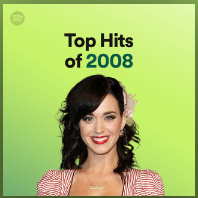 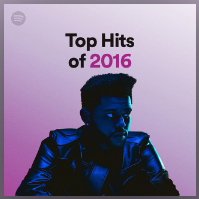

In [6]:
# subset of tracks that made top 100
TopSongs = df[df['Top100'] == "Y"]

In [7]:
len(TopSongs)

1863

The data sample runs from the year 2000 through 2021, and there are 100 tracks in the Top Songs list for each year.  This means that we were able to get 88% of possible records (1863/2100) in our data retrieval.

### Artists

Let's first take a look at the Artists that earned Top Song status over this time period

In [8]:
Artists_Grouped = TopSongs['artist_name'].value_counts().reset_index()
Artists_Grouped.index = Artists_Grouped.index + 1
Artists_Grouped.columns = ['Artist', 'Count']
Artists_Grouped.head(30)

,Artist,Count
1,Drake,26
2,Taylor Swift,25
3,Rihanna,25
4,Eminem,22
5,Ariana Grande,20
6,Calvin Harris,19
7,P!nk,18
8,Beyoncé,18
9,Britney Spears,16
10,Justin Bieber,16


_Observations:_

- We can see that there are five artists that had at least 20 Top Songs over this time period, and twenty-eight artists that had at least 10 Top Songs.

In [9]:
Artists_Grouped_Year = TopSongs[['artist_name', 'popular_year']].value_counts().reset_index()
Artists_Grouped_Year.index = Artists_Grouped_Year.index + 1
Artists_Grouped_Year.columns = ['Artist', 'Year', 'Count']
#Artists_Grouped_Year
Artists_Grouped_Year.head(30)

,Artist,Year,Count
1,Ed Sheeran,2017,5
2,Rihanna,2010,5
3,Lady Gaga,2009,5
4,Drake,2018,5
5,Doja Cat,2021,5
6,Marshmello,2018,4
7,Taylor Swift,2015,4
8,Calvin Harris,2013,4
9,Ariana Grande,2021,4
10,50 Cent,2003,4


_Observations:_

- The most Top Songs produced by an artist in any one year is five, and this has been done by five different artists.  Four Top Songs was much more frequent, having been achieved by fifteen different artists in the time period.

Let's view a time series of the top artists


In [10]:
top5Artists = list(Artists_Grouped['Artist'])[0:5]

In [11]:
top10Artists = list(Artists_Grouped['Artist'])[0:10]

In [12]:
Artist_GroupedTop10 = Artists_Grouped[0:10]

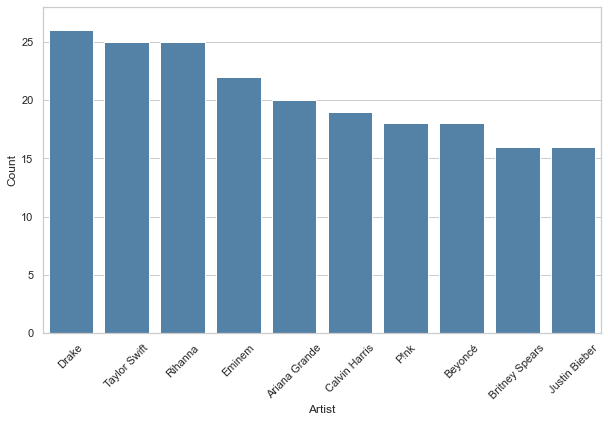

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="Artist", y="Count", data=Artist_GroupedTop10, color='steelblue')
ax.set_ylim(0, 28)
plt.xticks(rotation=45);

In [14]:
df2 = Artists_Grouped_Year.query("Artist in @top5Artists")
df2

,Artist,Year,Count
2,Rihanna,2010,5
4,Drake,2018,5
7,Taylor Swift,2015,4
9,Ariana Grande,2021,4
12,Ariana Grande,2019,4
28,Rihanna,2007,3
30,Rihanna,2008,3
31,Ariana Grande,2014,3
60,Ariana Grande,2016,3
61,Taylor Swift,2017,3


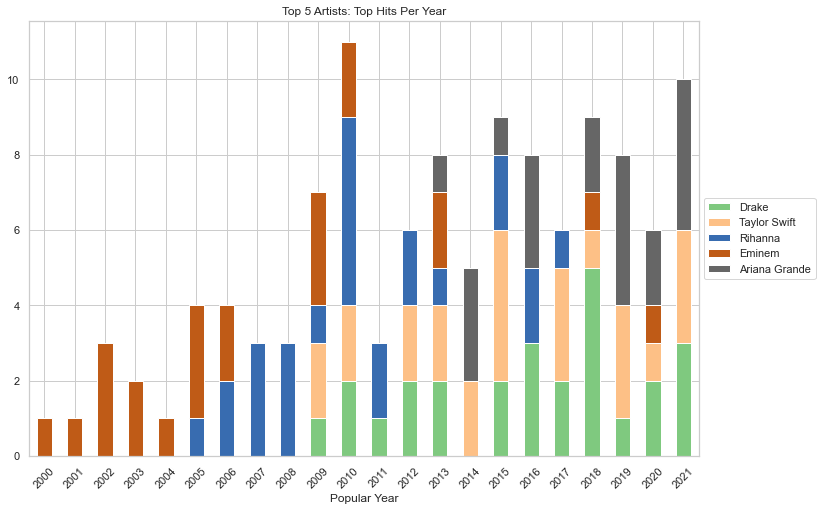

In [15]:
ctab = pd.crosstab([TopSongs['popular_year']], TopSongs['artist_name'])
ctab[top5Artists].plot(kind='bar', stacked=True, colormap='Accent', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Top 5 Artists: Top Hits Per Year")
plt.xticks(rotation=45)
plt.xlabel('Popular Year')
plt.show()

It looks like Eminmen and Rihanna dominated the period from 2000 to 2010.  Let's take a closer look at that time period.

In [16]:
FirstDecade = TopSongs.query("popular_year < 2011")
Artists_Grouped_FD = FirstDecade['artist_name'].value_counts().reset_index()
Artists_Grouped_FD.index = Artists_Grouped_FD.index + 1
Artists_Grouped_FD.columns = ['Artist', 'Count']
Artists_Grouped_FD.head(10)

,Artist,Count
1,Eminem,18
2,Rihanna,15
3,Britney Spears,13
4,Usher,12
5,Beyoncé,12
6,Black Eyed Peas,12
7,P!nk,10
8,Nelly,9
9,JAY-Z,9
10,Avril Lavigne,9


### Genres

#### Let's look at the most popular genres in the Top 100s

In [17]:
Genres_Grouped = TopSongs['track_genre'].value_counts().reset_index()
Genres_Grouped.index = Genres_Grouped.index + 1
Genres_Grouped.columns = ['Genre', 'Count']
Genres_Grouped['pct_of_total'] = Genres_Grouped.Count / Genres_Grouped.Count.sum()
#Genres_Grouped.loc[:, "pct_of_total"] = Genres_Grouped["pct_of_total"].map('{:.0%}'.format)
Genres_Grouped.loc[:, "pct_of_total"] = Genres_Grouped["pct_of_total"].map('{:,.2f}'.format)
Genres_Grouped.head(10)

,Genre,Count,pct_of_total
1,pop,1057,0.57
2,hip-hop,448,0.24
3,house,144,0.08
4,rock,88,0.05
5,indie,68,0.04
6,dance,19,0.01
7,alternative,19,0.01
8,country,13,0.01
9,r&b,7,0.00


We can see that pop, hip-hop, and house are the most dominant genres.

''

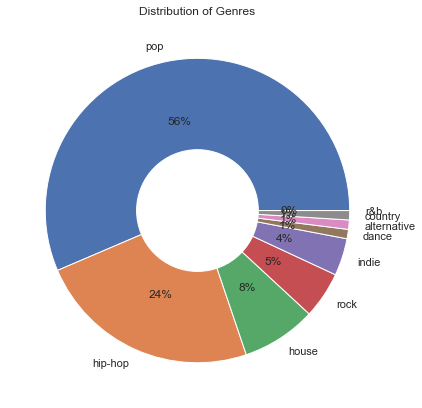

In [18]:
# Create a pieplot
plt.rcParams["figure.figsize"] = (7,7)
plt.title("Distribution of Genres")
plt.pie(Genres_Grouped['pct_of_total'], labels=Genres_Grouped['Genre'], labeldistance=1.1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct='%1.0f%%')
# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.4, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
;

#### Genres over time

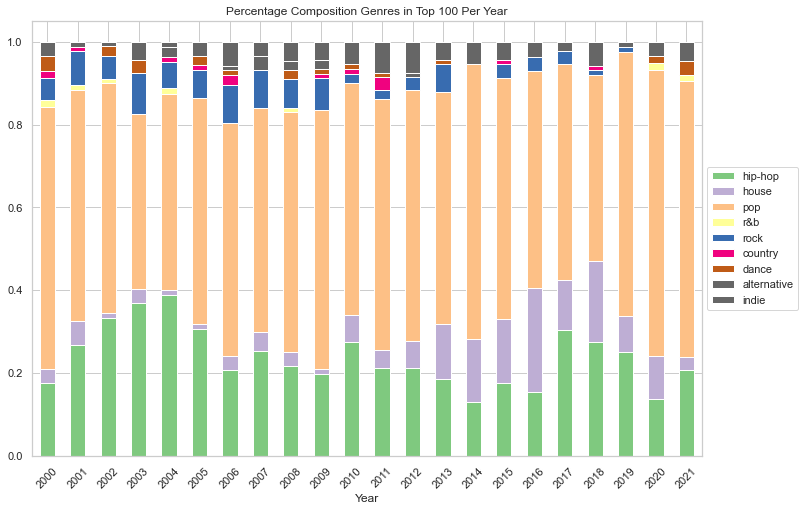

In [19]:
genres = ['hip-hop', 'house', 'pop', 'r&b', 'rock', 'country', 'dance', 'alternative', 'indie']
ctab = pd.crosstab([TopSongs['popular_year']], TopSongs['track_genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked=True, colormap='Accent', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percentage Composition Genres in Top 100 Per Year")
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.show()

_Observations on genres over time:_

- Pop and hip-hop have always maintained a sizeable portion of the Top Songs
- House music really began to hold a meaningful position starting in 2010
- Rock and Country music has faded in popularity in recent years

### Labels

#### Let's look at the Labels with the most songs in the Top 100s

In [20]:
TopLabels = TopSongs['Label'].value_counts().reset_index()
TopLabels.index = TopLabels.index + 1
TopLabels.columns = ['Label', 'Count']
TopLabels['pct_of_total'] = TopLabels.Count / TopLabels.Count.sum()
#Genres_Grouped.loc[:, "pct_of_total"] = Genres_Grouped["pct_of_total"].map('{:.0%}'.format)
TopLabels.loc[:, "pct_of_total"] = TopLabels["pct_of_total"].map('{:,.2f}'.format)
TopLabels.head(30)

,Label,Count,pct_of_total
1,Interscope,81,0.06
2,Atlantic,59,0.04
3,Capitol,53,0.04
4,Island,53,0.04
5,RCA,47,0.04
6,Jive,44,0.03
7,Def Jam,42,0.03
8,Warner Bros.,38,0.03
9,Columbia,36,0.03
10,Epic,34,0.03


_Observations:_

- There is a fair distribution of hits among labels, with no single label containing more than 6%.  However, the above data does not account for subsidiaries of the major labels. For example, Atlantic is a subsidiary of Warner Bros, and Capitol is a subsidiary of Universal.  If we were to combine all of the subsidiaries under their Major umbrella, I suspect the Majors (Universal, Warner, Sony)  would dominate the rankings.

### Artist Country of Origin

#### Let's look at artist country of origin for Top Songs

In [21]:
TopCountries = TopSongs['artist_country'].value_counts().reset_index()
TopCountries.index = TopCountries.index + 1
TopCountries.columns = ['Country', 'Count']
TopCountries['pct_of_total'] = TopCountries.Count / TopCountries.Count.sum()
#Genres_Grouped.loc[:, "pct_of_total"] = Genres_Grouped["pct_of_total"].map('{:.0%}'.format)
TopCountries.loc[:, "pct_of_total"] = TopCountries["pct_of_total"].map('{:,.2f}'.format)
TopCountries.head(30)

,Country,Count,pct_of_total
1,United States,1064,0.63
2,United Kingdom,285,0.17
3,Canada,117,0.07
4,Sweden,31,0.02
5,Australia,27,0.02
6,France,24,0.01
7,Jamaica,15,0.01
8,Netherlands,13,0.01
9,Ireland,11,0.01
10,Germany,10,0.01


_Observations:_

- Being from a country where English is the primary language is a major advantage for an artist, with the US, UK, Canada, Australia, and Ireland all appearing in the Top 10 and making up 90% of Top Songs.  This does not necessarily map to the locale of Spotify subscribers, with Europe comprising 39% of subs, North America comprising 28%, Latin America at 21%, and the Rest of the World at 12%. 
- I'm curious if there are certain countries that over-index on Top Songs, relative to the size of their populations.  Countries with large populations like the US and Germany aren't surprising to see in the Top 10.  But there are several others that are near the top of the list that are relatively small populations.


In [23]:
# import population data to merge with dataset
pop_detail = pd.read_csv("../Data/population_data.csv")

In [24]:
# merge the datasets
TopCountries = TopCountries.merge(pop_detail['pop2023'], how = 'left',
                left_on = 'Country', right_on = pop_detail['country'])
TopCountries.index = TopCountries.index + 1

In [25]:
# create 'hits_pop_ratio': the higher the ratio, the higher the number of hits relative to the population
TopCountries['hits_pop_ratio'] = (TopCountries['Count'] / TopCountries['pop2023'])*1000000
TopCountries.loc[:, 'hits_pop_ratio'] = TopCountries['hits_pop_ratio'].map('{:,.2f}'.format)

In [26]:
TopCountries.head(30)

,Country,Count,pct_of_total,pop2023,hits_pop_ratio
1,United States,1064,0.63,"339,996,563.0",3.13
2,United Kingdom,285,0.17,"67,736,802.0",4.21
3,Canada,117,0.07,"38,781,291.0",3.02
4,Sweden,31,0.02,"10,612,086.0",2.92
5,Australia,27,0.02,"26,439,111.0",1.02
6,France,24,0.01,"64,756,584.0",0.37
7,Jamaica,15,0.01,"2,825,544.0",5.31
8,Netherlands,13,0.01,"17,618,299.0",0.74
9,Ireland,11,0.01,"5,056,935.0",2.18
10,Germany,10,0.01,"83,294,633.0",0.12


Places like the UK, Canada, Jamaica, and Iceland produce a lot of hits relative to their populations, each having a ratio over 3.  The US also boasts a ratio over 3 in spite of its very large population!

### Collaborations

#### Let's look at how much of a factor collaborations are in creating hits

In [27]:
TopSongs.collaboration.value_counts()

N    1518
Y     345
Name: collaboration, dtype: int64

In [28]:
345/1863

0.18518518518518517

__Of all the Top Hits, about 19% were collaborations.__

In [29]:
TopCollabs2 = TopSongs.groupby(['popular_year']).collaboration.value_counts()
TopCollabs2

popular_year  collaboration
2000          N                56
              Y                 1
2001          N                78
              Y                 8
2002          N                80
              Y                10
2003          N                74
              Y                18
2004          N                74
              Y                 6
2005          N                78
              Y                10
2006          N                73
              Y                14
2007          N                78
              Y                 9
2008          N                77
              Y                11
2009          N                87
              Y                 4
2010          N                71
              Y                20
2011          N                81
              Y                13
2012          N                82
              Y                12
2013          N                68
              Y                23
2014          N     

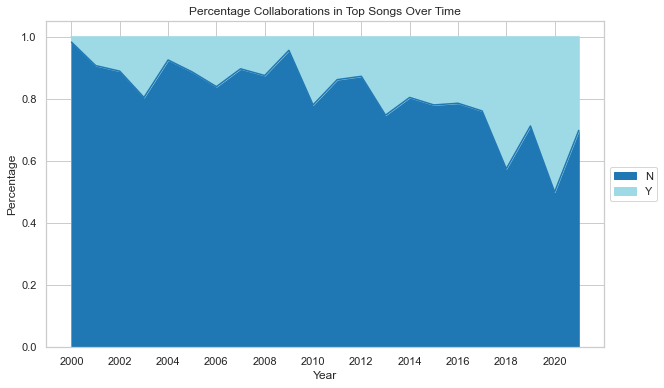

In [30]:
collab_values = ['N', 'Y']
ctab = pd.crosstab([TopSongs['popular_year']], TopSongs['collaboration']).apply(lambda x: x/x.sum(), axis=1)
ctab[collab_values].plot(kind='area', stacked=True, colormap='tab20', figsize=(10,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Percentage Collaborations in Top Songs Over Time")
plt.xticks(np.arange(min(TopSongs['popular_year']), max(TopSongs['popular_year'])+1, 2.0))
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.show()

_Observations:_

- We can see in the chart above that the prevalence of collaobrations in Top Hits has increased over time, hitting an all-time peak in 2020.
    

### Audio Features

#### Let's now take a look at audio features that Spotify provides for songs.

Most of these audio features are on a scale of 0 to 1, while others have nuanced scales specific to that characteritic  

Full deatils on each of these audio features can be found at Spotify's developer documentation: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

We'll first take a look at the audio features for all songs, not just the Top Hits.

In [31]:
#let's select only the audio features:
df_af = df[['key', 'acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'modality','speechiness', 'tempo', 'time_signature', 'valence']]

df_af.head()

,key,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,modality,speechiness,tempo,time_signature,valence
0,5.0,0.0302,0.949,"284,200.0",0.661,0.0,0.0454,-4.244,0.0,0.0572,104.504,4.0,0.76
12,4.0,0.143,0.843,"270,507.0",0.806,0.0,0.0771,-5.946,0.0,0.269,94.948,4.0,0.613
13,6.0,0.0371,0.78,"404,107.0",0.768,2.34e-06,0.518,-4.325,0.0,0.238,80.063,4.0,0.507
25,7.0,0.0616,0.85,"291,782.0",0.7,1.8e-06,0.244,-6.49,1.0,0.0478,101.875,4.0,0.722
31,5.0,0.0281,0.725,"240,027.0",0.64,0.0,0.099,-7.905,0.0,0.332,166.028,3.0,0.915


In [32]:
df_af.key.value_counts()

0.0     30352
7.0     30315
2.0     27049
9.0     25189
1.0     23885
5.0     22499
4.0     19380
11.0    19101
10.0    17121
8.0     15966
6.0     15823
3.0      8416
Name: key, dtype: int64

In [33]:
df_af.modality.value_counts()

1.0    163781
0.0     91315
Name: modality, dtype: int64

In [34]:
df_af.time_signature.value_counts()

4.0    220034
3.0     27219
5.0      4865
1.0      2853
0.0       125
Name: time_signature, dtype: int64

#### Examining the data closer, it appears that key, modality, and time_signature are all categorical variables.  These should be excluded from the statistical calculations that follow.

In [35]:
df_af = df_af.drop(columns=['key', 'modality', 'time_signature'])

In [36]:
df_af.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.0302,0.949,"284,200.0",0.661,0.0,0.0454,-4.244,0.0572,104.504,0.76
12,0.143,0.843,"270,507.0",0.806,0.0,0.0771,-5.946,0.269,94.948,0.613
13,0.0371,0.78,"404,107.0",0.768,2.34e-06,0.518,-4.325,0.238,80.063,0.507
25,0.0616,0.85,"291,782.0",0.7,1.8e-06,0.244,-6.49,0.0478,101.875,0.722
31,0.0281,0.725,"240,027.0",0.64,0.0,0.099,-7.905,0.332,166.028,0.915


''

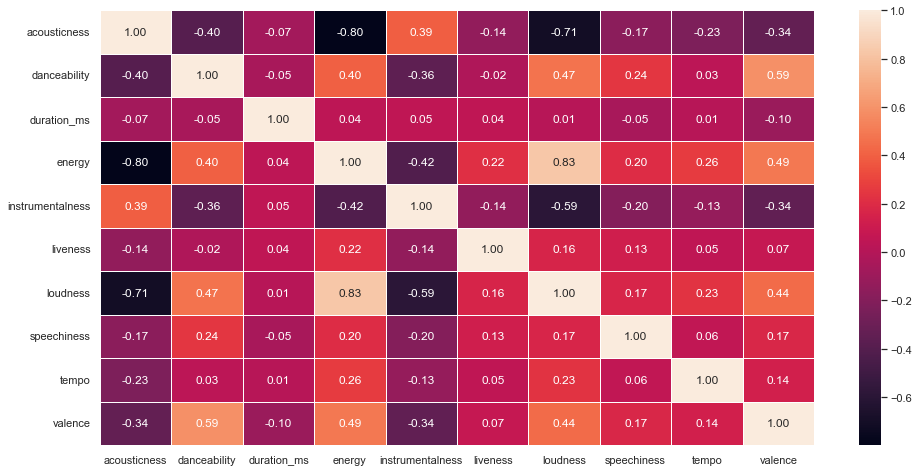

In [37]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_af.corr(), annot=True, linewidths=.5, ax=ax, fmt='.2f')
#sns.heatmap(df_af.corr(), annot=True, linewidths=.5, ax=ax, fmt='n')
;

### Observations on correlation matrix: 
There does not appear to be much widespread correlation between the availble variables.  The only variables with a coefficient higher than +_0.5 are:
 - Energy/Acousticness
 - Danceability/Valence
 - Loudness/Accousticness
 - Energy/Loudness
 - Acousticness/Loudness
 - Loudness/Instrumentalness
 
 It's worth noting that Loudness is included in four of these pairs (could be a candidate for removal)

In [38]:
df_af.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,"255,096.0","255,096.0","255,096.0","255,096.0","255,096.0","255,096.0","255,096.0","255,096.0","255,096.0","255,096.0"
mean,0.3625521091495698,0.5348137046445327,"241,788.11358468968",0.5603067801890222,0.2318679500838841,0.19167739392229846,-9.892241889327874,0.07808765601969404,118.28345210822593,0.4364670502320823
std,0.35979066553696226,0.19142109415217892,"121,100.377899359",0.2744642214065526,0.36054724479791045,0.16816846223531615,6.455129037345852,0.08733806861929208,30.238443091026834,0.26213229940867017
min,0.0,0.0,"8,213.0",0.0,0.0,0.0,-60.0,0.0,0.0,0.0
25%,0.0285,0.408,"183,347.0",0.356,0.0,0.0955,-11.948,0.0349,94.57775000000001,0.212
50%,0.216,0.552,"224,627.0",0.601,0.000486,0.122,-7.794,0.0445,118.43350000000001,0.421
75%,0.714,0.678,"274,994.0",0.79,0.501,0.22925,-5.58,0.0741,137.8555,0.646
max,0.996,0.988,"4,771,640.0",1.0,0.999,1.0,4.111,0.961,247.999,1.0


Let's now look at the audio features for just the Top Hits and compare them to the statistics above.

In [39]:
TopSongs_af = TopSongs[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness','speechiness', 'tempo', 'valence']]
TopSongs_af.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,"1,863.0","1,863.0","1,863.0","1,863.0","1,863.0","1,863.0","1,863.0","1,863.0","1,863.0","1,863.0"
mean,0.1458876331723028,0.6618819108964038,"228,045.07890499194",0.7001827160493819,0.011266102844873874,0.17523462157809983,-5.644538915727309,0.09928416532474509,120.1594712828771,0.5432691894793347
std,0.19207927443903192,0.13901805788859872,"40,292.28843762828",0.16089666120603166,0.07337201731594203,0.1353402881503544,1.9856227188452278,0.09398055636509238,27.347887105367672,0.22467933537394932
min,1.92e-05,0.162,"113,000.0",0.0519,0.0,0.021,-21.107,0.0232,60.019,0.0381
25%,0.0161,0.574,"202,183.0",0.594,0.0,0.0898,-6.6615,0.038849999999999996,98.037,0.3715
50%,0.0631,0.672,"223,547.0",0.717,0.0,0.12,-5.389,0.0581,119.988,0.547
75%,0.2025,0.759,"247,953.5",0.825,3.5850000000000004e-05,0.2235,-4.2595,0.118,136.0255,0.7295
max,0.978,0.975,"613,027.0",0.988,0.925,0.979,-0.276,0.576,210.857,0.974


Interestingly, these statistics appear to vary from the total song population and the Top Hits. Just eye-balling a few, acousticness, danceability, energy, instrumentalness, and loudness at least have meaningfully different means. Hopefully this bodes well for the modeling component that will come later. 

### Let's look at the distribution of numerical variables

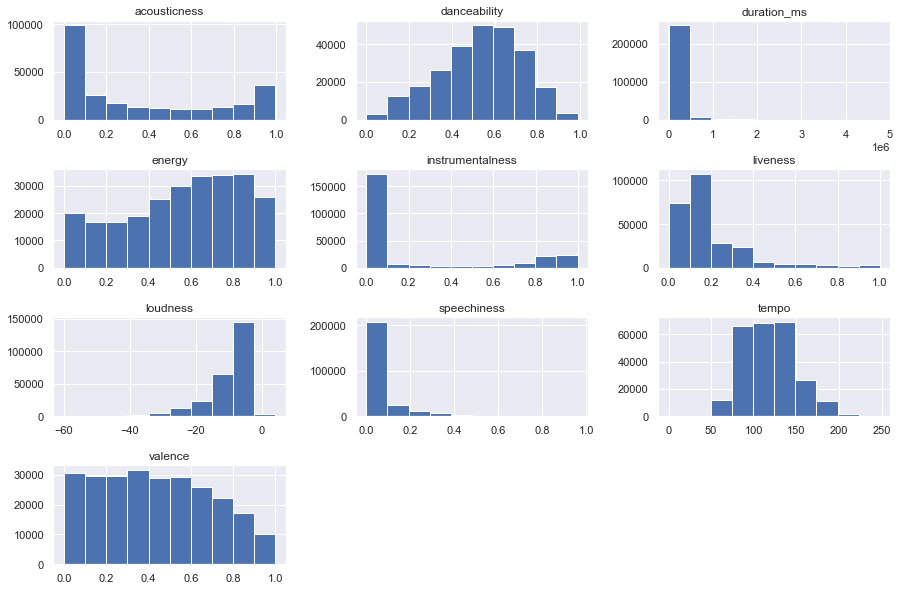

In [40]:
df_af.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

_Observations:_
- Only a few of these variables appear to potentially have a normal distribution.  I'll run a stats test below to check as well.
- It appears there could be the presence of outliers in duration_ms, liveness, loudness, speechiness, and tempo.


In [41]:
for column_name in df_af.columns:
    data = df_af[column_name]
    output = stats.normaltest(data)
    print(column_name,": ",output)
    #print(output)

acousticness :  NormaltestResult(statistic=490333.5367277308, pvalue=0.0)
danceability :  NormaltestResult(statistic=9198.026824847599, pvalue=0.0)
duration_ms :  NormaltestResult(statistic=361867.8617219839, pvalue=0.0)
energy :  NormaltestResult(statistic=45718.50753011556, pvalue=0.0)
instrumentalness :  NormaltestResult(statistic=42704.303430765176, pvalue=0.0)
liveness :  NormaltestResult(statistic=123824.05279573602, pvalue=0.0)
loudness :  NormaltestResult(statistic=78512.68282741038, pvalue=0.0)
speechiness :  NormaltestResult(statistic=183244.08178366284, pvalue=0.0)
tempo :  NormaltestResult(statistic=5570.21642814614, pvalue=0.0)
valence :  NormaltestResult(statistic=72809.82292465563, pvalue=0.0)


#### All of the very low p-values above indicate that none of these variables is in fact normally distributed.